# Digital Signal Processing Project
## Neural Network for Digital Signal Processing(NN4DSP)
### Dong Xu, Arthur Redfern, Diana Aleksieva

## 1. Introduction

The goal of project is ...

## 2. Background

## 3. Method

## 4. Implementation

### 4.1 Setup

In [2]:
import os
import time
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt


### 4.2 Dataset Generation

In [3]:
_SAMPLE_DIR = "_assets"
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)


In [4]:
dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)
print(len(dataset))

waveform, sample_rate, label = dataset[0]
waveform = waveform.numpy()
display(Audio(waveform[0],rate=sample_rate,))


60


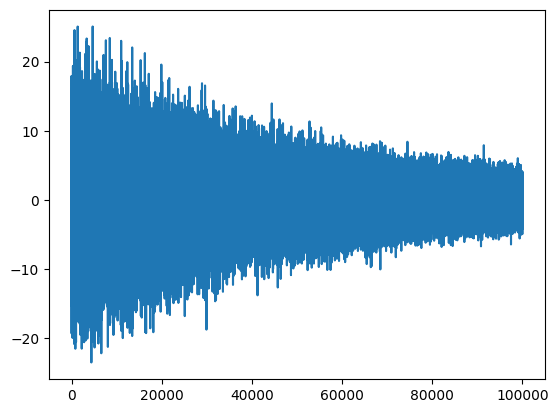

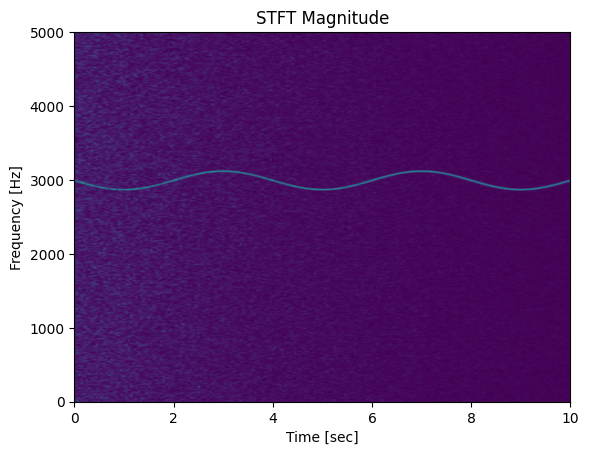

/home/edward/Work/NN4DSP/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


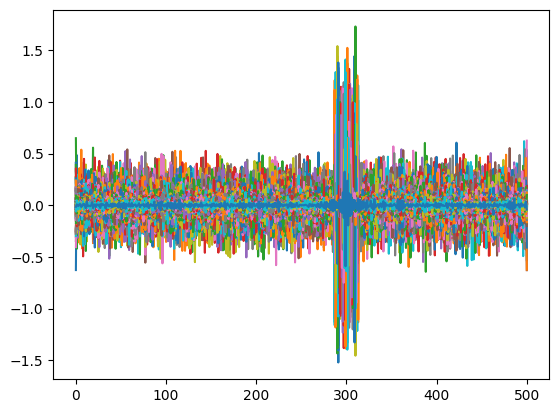

In [5]:
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power),
                   size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

#print(x, min(x), max(x))
plt.plot(x)
plt.show()
f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.plot(Zxx)
plt.show()

3176


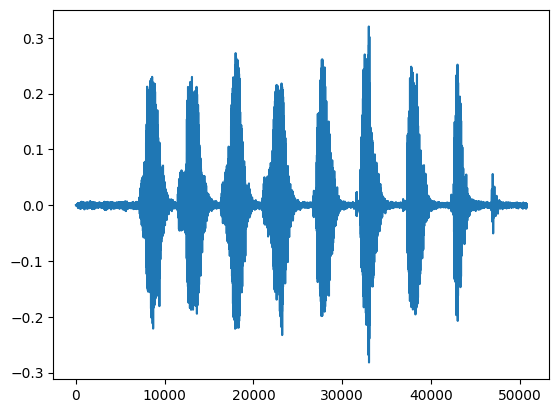

(50800,) [ 3.0517578e-05  6.1035156e-05  3.0517578e-05 ... -1.8615723e-03
 -2.2583008e-03 -1.3732910e-03] -0.28201294 0.32043457
(17, 3176)


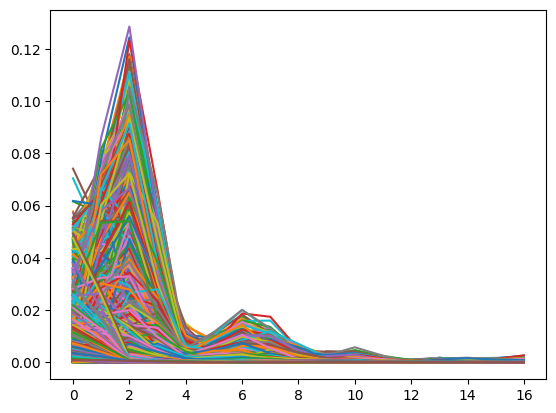

In [6]:
rng = np.random.default_rng()

wl = 32 # window_length

x = waveform[0]

data0 = []
for i in range((len(x) + wl//2)//(wl//2)):
    data0 += [x[wl//2*i : wl//2*i+wl]]
print(len(data0))

plt.plot(x)
plt.show()

print(x.shape, x, min(x), max(x))

f, t, Zxx = signal.stft(x, nperseg=wl)

print(np.abs(Zxx).shape)

plt.plot(np.abs(Zxx))
plt.show()

In [7]:
n_epochs = 64
#n_epochs = 1 # for test
learning_rate = 1e-2
momentum = 0.9
log_interval = 512
device = 'cpu'
train_batch_size = 64
test_batch_size = 64
window_length = 32

model_name = 'NetS'
#model_name = 'NetM'
#model_name = 'NetL'

In [8]:

# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class STFTDataset(Dataset):

    def __init__(self, dataset, wl=32):
        data = []
        label = []
        for x,_,_ in dataset:
            x = x[0].numpy()
            for i in range((len(x) + wl//2)//(wl//2)):
                temp = list(x[wl//2*i : wl//2*i+wl])
                
                temp += [0] * (wl-len(temp))
                if len(temp) != wl:
                    print(len(temp))
                    
                data += [temp]
            
            f, t, Zxx = signal.stft(x, fs, nperseg=wl)
            
            for y in np.abs(Zxx).T:
                label += [y]
            
        self.data = np.array(data, dtype=np.float32)
        self.label = np.array(label, dtype=np.float32)
        
        assert len(self.data) == len(self.label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx], self.label[idx]

train_dataset = STFTDataset([dataset[i] for i in range(50)], wl=window_length)
test_dataset = STFTDataset([dataset[i] for i in range(50,60)], wl=window_length)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(f'Size of train dataset: {len(train_dataloader)}')
print(f'Size of test dataset: {len(test_dataloader)}')


Size of train dataset: 2392
Size of test dataset: 483


### 4.3 Neural Network Architectures

In [9]:
class NetS(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetS, self).__init__()
        self.fc1 = nn.Linear(dim_in, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(128, dim_out)

    def forward(self, x):
        x = x.view(-1,32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.out(x)
        return x


class NetM(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetM, self).__init__()
        self.fc1 = nn.Linear(dim_in, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(512, dim_out)

    def forward(self, x):
        x = x.view(-1,32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.out(x)
        return x
    
class NetL(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetL, self).__init__()
        self.fc1 = nn.Linear(dim_in, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 512)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(512, 512)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(512, 512)
        self.relu6 = nn.ReLU()
        self.out = nn.Linear(512, dim_out)

    def forward(self, x):
        x = x.view(-1,32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.out(x)
        return x

model = eval(model_name)(32, 17).to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
print(model)

NetS(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (out): Linear(in_features=128, out_features=17, bias=True)
)


### 4.4 Neural Network Training

In [10]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % log_interval == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    accs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item()
            
            acc = np.divide(np.abs((output.numpy()-target.numpy())), target.numpy())
            accs +=[np.mean(acc)]
            
    test_loss /= len(test_loader.dataset)
    accuracy = np.mean(accs)

    #print('Iter: {} Test set: Average loss: {:.4f}\n'.format(epoch, test_loss))
    return test_loss, accuracy

In [60]:
losses = []
for epoch in range(1, n_epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch, 1000)
    loss,_ = test(model, device, test_dataloader, epoch)
    losses += [loss]
    
    path = f'res/{model_name}_{epoch}'
    torch.save(model.state_dict(), f'{path}.pt')
    torch.onnx.export(model,                                # model being run
                  torch.randn(window_length).to(device),    # model input (or a tuple for multiple inputs)
                  f"{path}.onnx",           # where to save the model (can be a file or file-like object)
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'])            # the model's output names
print(losses)

[0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.0011498941878197023, 0.00114989

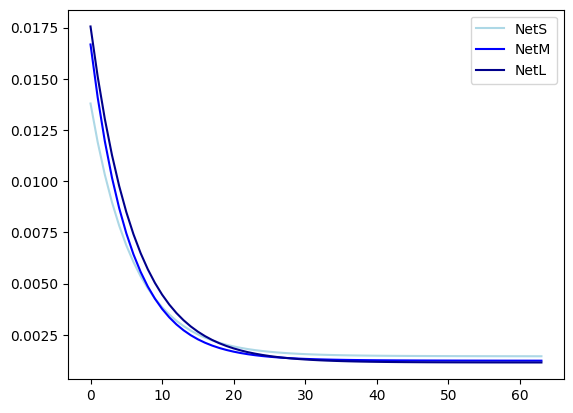

In [ ]:
# net_s
losses = [0.013794145123525099, 0.011910912188790524, 0.010318274033685845, 0.008972969087267246, 0.007835484226781339, 0.006871830617815493, 0.006054938058280574, 0.005361836697598984, 0.004773933932805753, 0.004275088411671496, 0.0038519725876010194, 0.0034929729114932385, 0.0031880283837205604, 0.0029293142152270126, 0.0027096061222828725, 0.0025229652161558895, 0.0023644734427557446, 0.0022299030391833537, 0.0021156372489014364, 0.002018523062672149, 0.0019360478179478902, 0.001866001709453548, 0.0018064366772938703, 0.0017558138793401675, 0.001712823156545096, 0.001676237001713879, 0.0016450950422516963, 0.0016185708945244913, 0.001595963523899006, 0.0015766948349550524, 0.0015602525832981785, 0.001546202821355525, 0.001534187432672521, 0.0015239099129594367, 0.0015151031656856911, 0.0015075463038499298, 0.0015010496278797048, 0.0014954589340661346, 0.0014906409371471003, 0.0014864826100733383, 0.0014828843306152418, 0.0014797606815215307, 0.0014770424736745497, 0.0014746669516208237, 0.0014725842745257794, 0.0014707532613229576, 0.001469135621403833, 0.0014677000999087874, 0.0014664175997459073, 0.0014652676963365226, 0.0014642308196821088, 0.0014632911959008346, 0.0014624327260006616, 0.0014616452870288934, 0.0014609183031166755, 0.0014602440362049137, 0.0014596142419684075, 0.0014590237947901357, 0.0014584660488512083, 0.0014579367602802118, 0.0014574326993603264, 0.0014569501404164097, 0.0014564860768430871, 0.0014560381547908422]
plt.plot(losses, color='lightblue', label='NetS')
# net_m
losses = [0.016676212237519125, 0.014094289459965445, 0.011951227188641587, 0.010172414483861393, 0.008693016003415875, 0.007459854109179855, 0.0064319352732690295, 0.005575376422811687, 0.004861533632699664, 0.004266476450544415, 0.0037704098368435738, 0.0033567658306650782, 0.003011846162041936, 0.0027241413100462467, 0.0024840750639617995, 0.0022837359612749375, 0.0021164575684045955, 0.001976682970415317, 0.0018598657176550524, 0.0017622631638873928, 0.0016805955560328875, 0.0016122179042039042, 0.0015549184342481352, 0.0015068312531741305, 0.0014664485224473902, 0.0014324893978738434, 0.0014039264167105866, 0.0013798506285290753, 0.0013595399024362521, 0.0013423876997323086, 0.0013278970996220057, 0.0013156238708206232, 0.0013052241425171042, 0.0012963999384536366, 0.0012888953194527457, 0.0012824947394163811, 0.0012770341626401514, 0.0012723674440569, 0.0012683667048293957, 0.0012649351070369251, 0.0012619791645843434, 0.0012594284667609176, 0.0012572196960673183, 0.0012552946228612462, 0.0012536167727641156, 0.0012521449237273502, 0.001250845244300122, 0.0012496928737008785, 0.0012486684214268824, 0.001247750528633964, 0.0012469249221509415, 0.0012461801351572798, 0.001245501002820797, 0.0012448812208075474, 0.0012443126992732552, 0.0012437859796418631, 0.0012432955540179376, 0.0012428381524043162, 0.0012424084321243935, 0.0012420025392895946, 0.001241615254252671, 0.0012412473152199493, 0.0012408940586362718, 0.0012405547018495985]
plt.plot(losses, color='blue', label = 'NetM')
# net_l
losses = [0.0175542369694981, 0.015113209536426787, 0.013038057200894366, 0.011273500372797101, 0.009772612925137756, 0.00849641858734549, 0.0074131494072563085, 0.0064907159464920655, 0.005705118518225514, 0.005036089840984831, 0.004466121341218788, 0.003980674665753873, 0.0035669116853576216, 0.003214124243647908, 0.0029132898960922355, 0.002656770971778909, 0.0024378666561564754, 0.0022510393822254477, 0.0020915991742585867, 0.0019555117856464247, 0.0018393395474025735, 0.001740079594625417, 0.0016553020237574814, 0.0015828584616192154, 0.001520981688280002, 0.0014681018995499325, 0.0014228805943009334, 0.0013841750275849537, 0.001351044905033754, 0.0013226836495550587, 0.0012983979897404864, 0.0012776105670858156, 0.0012598047393498353, 0.001244549534392693, 0.0012314837661833947, 0.0012202838056735432, 0.0012106793838820408, 0.0012024414700247243, 0.0011953810794033584, 0.0011893289538592057, 0.0011841337535795343, 0.001179669760067992, 0.0011758376052505028, 0.001172545672777821, 0.0011697156393873046, 0.0011672787877574523, 0.0011651801874233599, 0.0011633673323545647, 0.0011618002036532374, 0.001160443631667729, 0.0011592696429299847, 0.001158252167342654, 0.0011573690829384759, 0.0011566019214142196, 0.0011559353473914263, 0.0011553537184087307, 0.0011548480091037284, 0.001154405741979978, 0.0011540192548454827, 0.0011536807389807646, 0.001153383821210071, 0.0011531244300042036, 0.001152895771009566, 0.0011526942737261686]

plt.plot(losses, color='darkblue', label='NetL')
plt.legend()

In [65]:
model_name = 'NetS'
model = eval(model_name)(32, 17).to(device)
model.load_state_dict(torch.load(f'res/{model_name}_64.pt'))
_, acc = test(model, device, test_dataloader, 0)
print('Accuracy of Net_S:', acc)

model_name = 'NetM'
model = eval(model_name)(32, 17).to(device)
model.load_state_dict(torch.load(f'res/{model_name}_64.pt'))
_, acc = test(model, device, test_dataloader, 0)
print('Accuracy of NetM:', acc)

model_name = 'NetL'
model = eval(model_name)(32, 17).to(device)
model.load_state_dict(torch.load(f'res/{model_name}_64.pt'))
_, acc = test(model, device, test_dataloader, 0)
print('Accuracy of NetL:', acc)

Accuracy of Net_S: 33.88573
Accuracy of NetM: 21.88012
Accuracy of NetL: 17.151247


In [31]:
def eval_model(model_name, test_dataloader, test_dataset, device):
    model = eval(model_name)(32, 17).to(device)
    model.load_state_dict(torch.load(f'res/{model_name}_64.pt'))
    _, acc = test(model, device, test_dataloader, 0)
    print('Accuracy of Net_S:', acc)

    test_x, test_y = test_dataset[1042]

    plt.plot(test_x, 'blue', label='Original Signal')
    
    import time
    start = time.time()
    pred = model(torch.tensor(test_x))
    end = time.time()
    print('Time of NN (s):', end - start)
    print('Predicted: ', pred)

    start = time.time()
    label = scipy.fft.rfft(test_x)
    label_magnitude = np.abs(label)
    end = time.time()
    print('Time of Scipy rfft (s):',end - start)
    print('test_y: ', test_y)
    print('FFT: ', label_magnitude)
    
    pred = pred.detach().numpy()[0]

    plt.plot(pred, 'red', label=f'Predict of {model_name}')
    plt.plot(label_magnitude, 'orange', label='FFT')
    plt.plot(test_y, 'green', label='label')
    plt.legend()
    plt.show()

Accuracy of Net_S: 33.88573
Time of NN (s): 0.0010726451873779297
Predicted:  tensor([[ 0.0057,  0.0011,  0.0116,  0.0074,  0.0018,  0.0055, -0.0025,  0.0035,
          0.0009, -0.0058,  0.0033, -0.0023,  0.0137, -0.0078, -0.0116,  0.0029,
         -0.0041]], grad_fn=<AddmmBackward0>)
Time of Scipy rfft (s): 6.890296936035156e-05
test_y:  [1.2813814e-02 1.9636460e-02 3.8372427e-02 1.5810614e-02 5.6188856e-04
 7.7572861e-04 1.7622731e-03 2.5929699e-03 1.8833892e-03 1.1642075e-03
 2.0173325e-03 1.4164564e-03 6.8443239e-04 9.3447266e-04 4.1745891e-04
 6.0530372e-05 3.0222745e-04]
FFT:  [0.5027771  1.1691048  0.9094376  0.25628668 0.15331982 0.14705369
 0.08525428 0.18285699 0.12447403 0.07925403 0.09004292 0.00848623
 0.00702068 0.01381857 0.02169027 0.01840264 0.01412964]


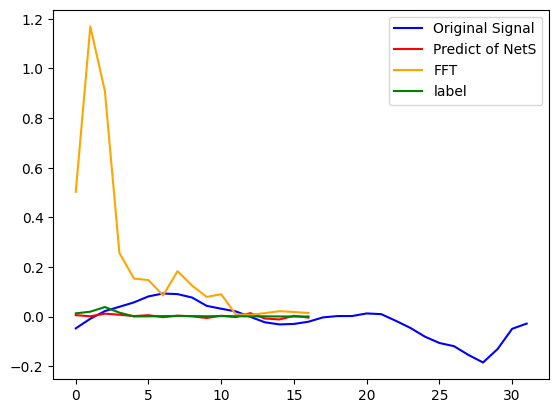

In [32]:
eval_model('NetS', test_dataloader, test_dataset, device)

### 4.5 Neural Network Verification

In [67]:
# generate property
center_point = [-0.047576904, -0.008758545, 0.021911621, 0.039398193, 0.05706787, 0.08129883, 0.09283447, 0.090423584, 0.0765686, 0.043182373, 0.031555176, 0.020751953, -0.0010986328, -0.023101807, -0.031707764, -0.029785156, -0.020812988, -0.003326416, 0.0019836426, 0.0021362305, 0.012542725, 0.009735107, -0.017059326, -0.04559326, -0.0809021, -0.106536865, -0.11932373, -0.15481567, -0.18508911, -0.13092041, -0.049346924, -0.028411865]


epsilons = [0.01,0.02,0.04,0.08]
gamma = 0.01

for epsilon in epsilons:
    nnv_lines = ['from dnnv.properties import *',
                'import numpy as np',
                '',
                'N = Network("N")',
                f'x = np.array({center_point}, dtype=np.float32)',
                f'epsilon = {epsilon}',
                f'gamma = {gamma}',
                "output = N(x)",
                "gamma_lb = output-gamma",
                "gamma_ub = output+gamma",
                'Forall(',
                '    x_,',
                '    Implies(',
                '        ((x - epsilon) < x_ < (x + epsilon)),',
                '        (gamma_lb <= N(x_) <= gamma_ub)',
                '    ),',
                ')']
    nnv_lines = [x+'\n' for x in nnv_lines]
    open(f'properties/robustness_{epsilon}_{gamma}.dnnp', 'w').writelines(nnv_lines)



In [6]:
# run verifiers
verifier = 'neurify'
timeout = 60
cmd_prefix = f'python3 ../DNNV/tools/resmonitor.py -T {timeout} ./run_DNNV.sh'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [7]:
cmd = f'{cmd_prefix} properties/robustness_0.01_0.01.dnnp --network N res/NetS_64.onnx --{verifier}'
os.system(cmd)

INFO     2023-05-01 12:06:25,622 (resmonitor) Duration: 0.010s, MemUsage: 14.45M


Verifying property:
Forall(x_, ((([-0.058 -0.019 ... -0.059 -0.038] < x_) & (x_ < [-0.038 0.001 ... -0.039 -0.018])) ==> (((N([-0.048 -0.009 ... -0.049 -0.028]) - 0.01) <= N(x_)) & (N(x_) <= (0.01 + N([-0.048 -0.009 ... -0.049 -0.028]))))))

Verifying Networks:
N:
Input_0                         : Input([32], dtype=float32)
Reshape_0                       : Reshape(Input_0, [-1 32])
Gemm_0                          : Gemm(Reshape_0, ndarray(shape=(128, 32)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_0                          : Relu(Gemm_0)
Gemm_1                          : Gemm(Relu_0, ndarray(shape=(128, 128)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_1                          : Relu(Gemm_1)
Gemm_2                          : Gemm(Relu_1, ndarray(shape=(17, 128)), ndarray(shape=(17,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)



INFO     2023-05-01 12:06:30,675 (resmonitor) Duration: 5.067s, MemUsage: 377.07M


dnnv.verifiers.neurify
  result: unsat
  time: 2.2723


INFO     2023-05-01 12:06:31,727 (resmonitor) Duration: 6.120s, MemUsage: 0
INFO     2023-05-01 12:06:31,727 (resmonitor) Process finished successfully.


0

In [8]:
# timeout
cmd = f'./run_DNNV.sh properties/robustness_0.02_0.01.dnnp --network N res/NetS_64.onnx --{verifier}'
os.system(cmd)

Verifying property:
Forall(x_, ((([-0.068 -0.029 ... -0.069 -0.048] < x_) & (x_ < [-0.028 0.011 ... -0.029 -0.008])) ==> (((N([-0.048 -0.009 ... -0.049 -0.028]) - 0.01) <= N(x_)) & (N(x_) <= (0.01 + N([-0.048 -0.009 ... -0.049 -0.028]))))))

Verifying Networks:
N:
Input_0                         : Input([32], dtype=float32)
Reshape_0                       : Reshape(Input_0, [-1 32])
Gemm_0                          : Gemm(Reshape_0, ndarray(shape=(128, 32)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_0                          : Relu(Gemm_0)
Gemm_1                          : Gemm(Relu_0, ndarray(shape=(128, 128)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_1                          : Relu(Gemm_1)
Gemm_2                          : Gemm(Relu_1, ndarray(shape=(17, 128)), ndarray(shape=(17,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)



In [5]:
cmd = f'./run_DNNV.sh properties/robustness_0.04_0.01.dnnp --network N res/NetS_64.onnx --{verifier}'
os.system(cmd)

2023-05-01 12:06:10.223071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 12:06:10.223166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Verifying property:
Forall(x_, ((([-0.088 -0.049 ... -0.089 -0.068] < x_) & (x_ < [-0.008 0.031 ... -0.009 0.012])) ==> (((N([-0.048 -0.009 ... -0.049 -0.028]) - 0.01) <= N(x_)) & (N(x_) <= (0.01 + N([-0.048 -0.009 ... -0.049 -0.028]))))))

Verifying Networks:
N:
Input_0                         : Input([32], dtype=float32)
Reshape_0                       : Reshape(Input_0, [-1 32])
Gemm_0                          : Gemm(Reshape_0, ndarray(shape=(128, 32)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_0                          : Relu(Gemm_0)
Gemm_1                          : Gemm(Relu_0, ndarray(shape=(128, 128)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_1                          : Relu(Gemm_1)
Gemm_2                          : Gemm(Relu_1, ndarray(shape=(17, 128)), ndarray(shape=(17,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)

dnnv.verifiers.neurify
  result: sat
  time: 0

2023-05-01 12:06:12.545991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-01 12:06:12.546072: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 12:06:12.546146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eOS): /proc/driver/nvidia/version does not exist
2023-05-01 12:06:12.546543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0

In [4]:
cmd = f'./run_DNNV.sh properties/robustness_0.08_0.01.dnnp --network N res/NetS_64.onnx --{verifier}'
os.system(cmd)

2023-05-01 12:06:04.998614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 12:06:04.998708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Verifying property:
Forall(x_, ((([-0.128 -0.089 ... -0.129 -0.108] < x_) & (x_ < [0.032 0.071 ... 0.031 0.052])) ==> (((N([-0.048 -0.009 ... -0.049 -0.028]) - 0.01) <= N(x_)) & (N(x_) <= (0.01 + N([-0.048 -0.009 ... -0.049 -0.028]))))))

Verifying Networks:
N:
Input_0                         : Input([32], dtype=float32)
Reshape_0                       : Reshape(Input_0, [-1 32])
Gemm_0                          : Gemm(Reshape_0, ndarray(shape=(128, 32)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_0                          : Relu(Gemm_0)
Gemm_1                          : Gemm(Relu_0, ndarray(shape=(128, 128)), ndarray(shape=(128,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)
Relu_1                          : Relu(Gemm_1)
Gemm_2                          : Gemm(Relu_1, ndarray(shape=(17, 128)), ndarray(shape=(17,)), transpose_a=0, transpose_b=1, alpha=1.000000, beta=1.000000)

dnnv.verifiers.neurify
  result: sat
  time: 0.1

2023-05-01 12:06:07.283913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-01 12:06:07.283993: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 12:06:07.284066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eOS): /proc/driver/nvidia/version does not exist
2023-05-01 12:06:07.284478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0

## 5. Conclusion and Future Work